In [1]:
from scipy.integrate import ode

%pylab inline
import numpy as np

def solve(f, Xs, Y0, with_h = 1.):
    X0, XF = Xs
    r = ode(f)
    r.set_initial_value(Y0, X0)

    dt = with_h
    Xs = []
    Ys = []
    
    max_iter = 1e6
    while r.successful() and r.t < XF and max_iter > 0:
        r.integrate(r.t + dt)
        Xs.append(r.t)
        Ys.append(r.y)
        max_iter -= 1
    return Xs, Ys

Populating the interactive namespace from numpy and matplotlib


In [2]:
g, l, k, m = [10., 7., 10., 2.]

X0 = 0
XF = 10
Y0 = [.5, 0., 0., 0.]

In [3]:
def f(t, Ys):
    th, dth, x, dx = Ys
    ddx = (l+x)*dth**2 - k/m*x + g*np.cos(th)
    ddth = (-g*np.sin(th) - 2*dx*dth)/(l+x)
    return np.array([dth, ddth, dx, ddx])

In [4]:
Xs, Ys = solve(f, (X0, XF), Y0, with_h = 1e-4)

In [5]:
def plot_trajectory(Ys):
    ths = array(Ys)[:, 0]
    ls = array(Ys)[:, 2]
    Xs = (l+ls)*np.sin(ths)
    Ys = -(l+ls)*np.cos(ths)
    plot(Xs, Ys)
    plot(0., 0., 'ro')

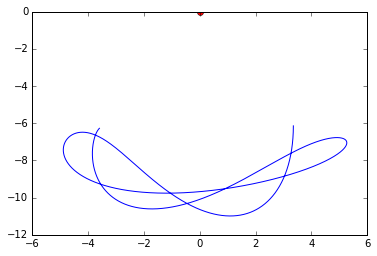

In [6]:
plot_trajectory(Ys)

In [7]:
def anim(Ys, fps = 10, d=5):
    import matplotlib.pyplot as plt
    from matplotlib import animation
    import numpy as np

    from embed_gif import from_anim

    fig = plt.figure()
    fig.set_dpi(100)
    fig.set_size_inches(7, 6.5)

    ax = plt.axes(xlim=(-6, 6), ylim=(-10, 2))
    patch = plt.Circle((5, -5), 0.75, fc='y')
    spring, = ax.plot([], [], '-', lw=2)
    path, = ax.plot([0],[0], '--', lw=1)
    path_x, path_y = [], []
    
    ths = array(Ys)[:, 0]
    ls = array(Ys)[:, 2]
    base_l = l/2.
    
    nitems = len(Ys)
    nframes = fps*d
    
    scale = lambda i: i/nframes*nitems

    def init():
        patch.center = (0, 0)
        ax.add_patch(patch)
        path.set_data(path_x, path_y)
        spring.set_data([], [])
        return patch, path, spring

    def animate(i):
        k = scale(i)
        th, l = ths[k], ls[k]
        length = base_l + l
        x, y = (length*np.sin(th), -length*np.cos(th))
        patch.center = (x, y)
        path_x.append(x)
        path_y.append(y)
        path.set_data(path_x, path_y)
        spring.set_data([0,x], [0,y])
        
        return patch, spring

    anim = animation.FuncAnimation(fig, animate, 
                                   init_func=init, frames=nframes, interval=1./fps*1000, blit=True)
    return from_anim(anim)

/usr/lib/python3.5/site-packages/ipykernel/__main__.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


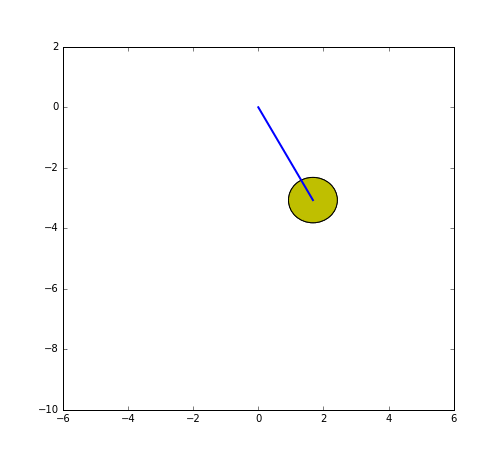

In [8]:
anim(Ys, d = 20, fps = 5)

In [9]:
from vapory import *

In [10]:
color = lambda col: Texture( Pigment( 'color', col))

def line(fro, to, width=0.1, color = color([1,.6,.5])):
    xf, yf = fro
    xt, yt = to
    xd = xt - xf
    yd = yt - yf
    
    length = np.sqrt(xd**2 + yd**2)
    th = np.rad2deg(np.arctan(xd/yd))
    x_act, y_act = ((-xt + xf + length*np.sin(np.deg2rad(th))), (yf + length*np.cos(np.deg2rad(th))))
    
    #assert((xt - x_act)**2 < 1e-2)
    #assert((yt - y_act)**2 < 1e-2)
    return Union(
                Box([-width/2, 0, 0], [width/2, length, 0],
                    color),
                'rotate', [0., 0., th],
                'translate', [xf, yf])

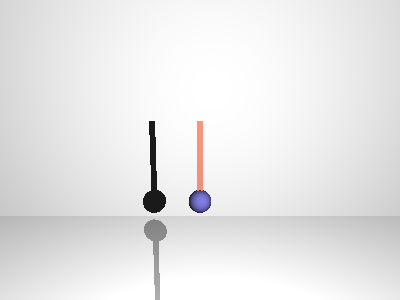

In [11]:
def scene(th, x):  
    wall = Plane([0, 0, 1], 20, Texture(Pigment('color', [1, 1, 1])))
    ground = Plane( [0, -20, 0], 10,
                Texture( Pigment( 'color', [1, 1, 1]),
                         Finish( 'phong', 0.1,
                                 'reflection',0.4,
                                 'metallic', 0.3)))

    radius = .2
    length = (x+l)/5.
    sphere = Sphere([0,0,0],
                    radius,
                    color([.5, .5, .9]),
                    'translate', [0., length, 0.])
    spring = line((0,0), (0, length))
    pendulum = Union(spring,
                     sphere,
                     'rotate', [0, 0, 180 + np.rad2deg(th)],
                     'translate', [0., 0.5, 0.])
    return Scene( Camera( 'location', [0, 1, -5], 'look_at',  [0, 0, 0] ),
            [ LightSource( [1, 1, -5], 'color', [1.5,1.5,1.5] ),
              Background( "color", [1,1,1] ),
              pendulum,
              wall,
              ground])
scene(0., 0.1).render('ipython', width=400, height=300)

In [12]:
import time
from moviepy.editor import VideoClip
from embed_gif import from_path

def anim(Ys, d=10, fps=30):
    ths = array(Ys)[:, 0]
    ls = array(Ys)[:, 2]
    ln = len(ls)
    scale = lambda t: int(t/d*ln)
    make_frame = lambda t: scene(ths[scale(t)], ls[scale(t)]).render(width = 400, height = 300, antialiasing=0.1)
    name = "anim_%d.gif" % time.time() 
    VideoClip(make_frame, duration=d).write_gif(name, fps=fps)
    return from_path(name)


[MoviePy] Building file anim_1462353168.gif with imageio


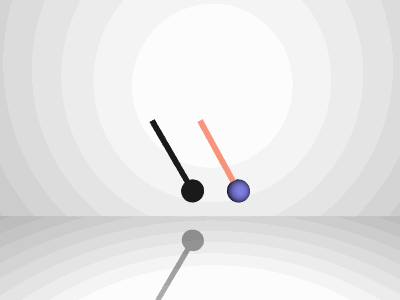

In [13]:
anim(Ys, d=10, fps=30)

In [14]:
g, l, k, m = [9.81, 3, 30., .5]

X0 = 0.
XF = 10.
Y0 = [.0, 0., 1.4, 0.]

R = -2.

In [15]:
L_1 = l
L_2 = l
m_1 = m
m_2 = m
def f(t, Ys):
    th_1, dth_1, th_2, dth_2 = Ys
    den = (2.*m_1 + m_2 - m_2*cos(2.*th_1 - 2.*th_2))
    ddth_den1 = L_1*den
    ddth_den2 = L_2*den
    ddth1 = sum([
                -g*(2.*m_1 + m_2)*np.sin(th_1),
                -m_2*g*np.sin(th_1 - 2.*th_2),
                -2.*np.sin(th_1 - th_2)*m_2*dth_2**2*L_2,
                -2.*np.sin(th_1 - th_2)*m_2*dth_1**2*L_1*np.cos(th_1 - th_2),
                R*dth_1
            ])
    ddth1 = ddth1 / ddth_den1
    ddth2 = sum([
                dth_1**2*L_1*(m_1 + m_2),
                g*(m_1 + m_2)*np.cos(th_1),
                dth_2**2*L_2*m_2*np.cos(th_1 - th_2),
                R*dth_2
            ])
    ddth2 = 2.*np.sin(th_1 - th_2) * ddth2 / ddth_den2
    return np.array([dth_1, ddth1, dth_2, ddth2])

In [16]:
Xs, Ys = solve(f, (X0, XF), Y0, with_h = 0.05)

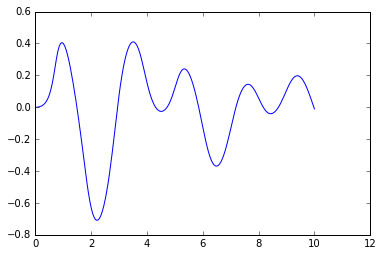

In [17]:
plot(Xs, array(Ys)[:, 0])

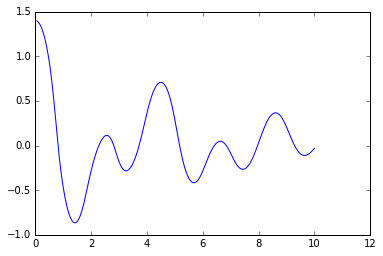

In [18]:
plot(Xs, array(Ys)[:, 2])

In [19]:
def anim(Ys, fps = 10, d=5):
    import matplotlib.pyplot as plt
    from matplotlib import animation
    import numpy as np

    from embed_gif import from_anim

    fig = plt.figure()
    fig.set_dpi(100)
    fig.set_size_inches(7, 6.5)

    ax = plt.axes(xlim=(-6, 6), ylim=(-10, 2))
    patch1 = plt.Circle((5, -5), 0.75, fc='y')
    spring1, = ax.plot([], [], '-', lw=2)
    
    patch2 = plt.Circle((5, -5), 0.75, fc='y')
    spring2, = ax.plot([], [], '-', lw=2)
    path2, = ax.plot([0],[0], 'g--', lw=1)
    path2_x, path2_y = [], []
    
    th1s = array(Ys)[:, 0]
    th2s = array(Ys)[:, 2]
    length = 4.
    
    nitems = len(Ys)
    nframes = fps*d
    
    scale = lambda i: i/nframes*nitems

    def init():
        ax.add_patch(patch1)
        ax.add_patch(patch2)
        return patch1, patch2

    def animate(i):
        k = scale(i)
        th1, th2 = th1s[k], th2s[k]
        x1, y1 = (length*np.sin(th1), -length*np.cos(th1))
        x2, y2 = (x1+length*np.sin(th2), y1-length*np.cos(th2))
        patch1.center = (x1, y1)
        patch2.center = (x2, y2)
        path2_x.append(x2)
        path2_y.append(y2)
        path2.set_data(path2_x, path2_y)
        spring1.set_data([0,x1], [0,y1])
        spring2.set_data([x1,x2], [y1,y2])
        
        return patch1, patch2, spring1, spring2

    anim = animation.FuncAnimation(fig, animate, 
                                   init_func=init, frames=nframes, interval=1./fps*1000, blit=True)
    return from_anim(anim)

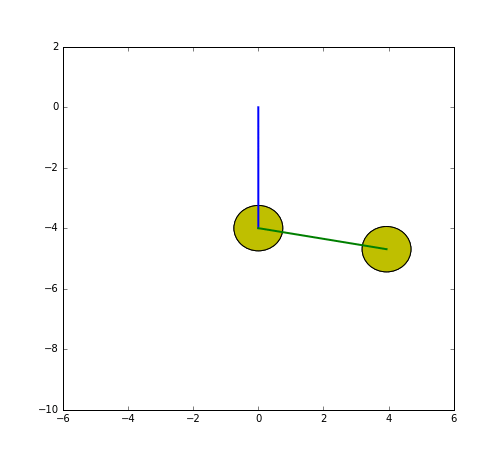

In [20]:
anim(Ys, d = 40, fps = 5)

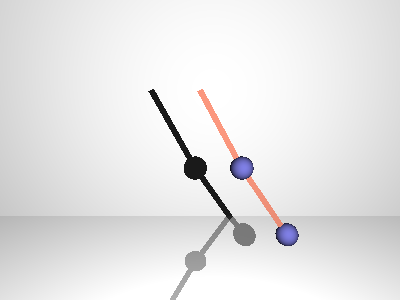

In [21]:
def scene(th1, th2):  
    wall = Plane([0, 0, 1], 20, Texture(Pigment('color', [1, 1, 1])))
    ground = Plane( [0, -20, 0], 10,
                Texture( Pigment( 'color', [1, 1, 1]),
                         Finish( 'phong', 0.1,
                                 'reflection',0.4,
                                 'metallic', 0.3)))

    radius = .2
    length = 1.5
    sphere = Sphere([0,0,0],
                    radius,
                    color([.5, .5, .9]),
                    'translate', [0., length, 0.])
    spring = line((0,0), (0, length))
    pendulum = Union(spring,
                     sphere,
                    Union(spring,
                         sphere,
                         'rotate', [0, 0, np.rad2deg(th2)],
                         'translate', [0., length, 0.]),
                    'rotate', [0, 0, 180 + np.rad2deg(th1)],
                    'translate', [0, 1, 0])
    return Scene( Camera( 'location', [0, 1, -5], 'look_at',  [0, 0, 0] ),
            [ LightSource( [1, 1, -5], 'color', [1.5,1.5,1.5] ),
              Background( "color", [1,1,1] ),
              pendulum,
              wall,
              ground])
scene(0.5, 0.1).render('ipython', width=400, height=300)

In [22]:
def anim(Ys, d=10, fps=30):
    ths = array(Ys)[:, 0]
    ls = array(Ys)[:, 2]
    ln = len(ls)
    scale = lambda t: int(t/d*ln)
    make_frame = lambda t: scene(ths[scale(t)], ls[scale(t)]).render(width = 400, height = 300, antialiasing=0.1)
    name = "anim_%d.gif" % time.time() 
    VideoClip(make_frame, duration=d).write_gif(name, fps=fps)
    return from_path(name)


[MoviePy] Building file anim_1462353452.gif with imageio


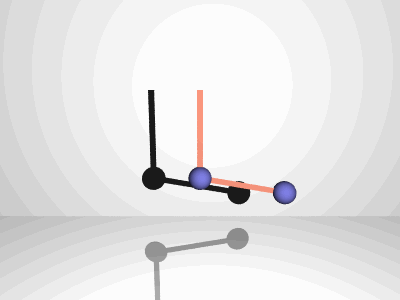

In [23]:
anim(Ys, d=5, fps=30)